# Exploring the radial properties of the hot-ICM temperature

<span style="color:red">This should currently be considered preliminary, as there are some problems with observation selection for spectral generation for some of these large clusters - also our improved background method isn't fully implemented. Also also, we are still using the MCXC defined coordinates</span>

<span style="color:red">**We do not currently make the temperature profile saves available, as I need to create a better file format for them (i.e. FITS based), and they are probably too large for GitHub right now.**</span>

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from shutil import rmtree
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import lovoccs_cosmo

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 50
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.temperature import min_cnt_proj_temp_prof  
from xga.sas.phot import emosaic
from xga.imagetools.misc import physical_rad_to_pix
from xga.exceptions import NoProductAvailableError
from xga.products import BaseAggregateProfile1D
from xga.imagetools.misc import pix_deg_scale

%matplotlib inline

xga.__version__

'v0.5.3+348.g42f8eb1c'

## Creating Storage Directories

We ensure that the storage directories within which we will store output files from this analysis have been created:

In [2]:
stor_dir = '../../outputs/results/profiles/projected_temperature/'
if not os.path.exists(stor_dir):
    os.makedirs(stor_dir)
    
fig_dir = '../../outputs/figures/profiles/projected_temperature/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
# And the same deal for projected metallicity
stor_dir_met = '../../outputs/results/profiles/projected_metallicity/'
if not os.path.exists(stor_dir_met):
    os.makedirs(stor_dir_met)
    
fig_dir_met = '../../outputs/figures/profiles/projected_metallicity/'
if not os.path.exists(fig_dir_met):
    os.makedirs(fig_dir_met)
    
# We also add a directory for side-by-side profile + ratemaps views
fig_dir_diag = '../../outputs/figures/profiles/projected_temperature_ratemaps/'
if not os.path.exists(fig_dir_diag):
    os.makedirs(fig_dir_diag)

## Cosmology

We use a cosmology that matches the other LoVoCCS works:

In [3]:
lovoccs_cosmo

LambdaCDM(name=None, H0=<Quantity 71. km / (Mpc s)>, Om0=0.2648, Ode0=0.7352, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=0.0448)

## Reading the sample file

We read in the sample file to get the information we need to set up an XGA ClusterSample:

In [4]:
# samp = pd.read_csv('../../outputs/results/ltr_r500_metfree_pipeline_results.csv')
# rad_hist = pd.read_csv('../../outputs/results/ltr_r500_metfree_radii_history.csv')

# samp = samp[~np.isnan(samp['r500'])]

# temp_samp = samp.merge(rad_hist)
# samp = samp[temp_samp['converged'].values]
# samp.reset_index(drop=True, inplace=True)
# samp

In [5]:
samp = pd.read_csv('../../sample_files/X-LoVoCCSI.csv')
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x))

# TODO REMOVE OF COURSE
samp = samp.sample(10, random_state=907)

samp

LoVoCCSID                       common_name    start_ra  start_dec  \
50        76                             A2556  348.250000 -21.630000   
2         4A                          A85North   10.458750  -9.301944   
44        65                             A1736  201.725000 -27.183333   
9         12                             A3571  206.870000 -32.850000   
30        45                             A2941   26.259583 -53.013889   
28       41C                        A1750South  202.556560  -2.094492   
31       46A                       A2440Centre  335.987686  -1.583249   
62       121                             A3128   52.466189 -52.580728   
61       119  RX J0820.9+0751/RXC J0821.0+0751  125.258665   7.863501   
43        63                             A2050  229.080000   0.100000   

    MCXC_Redshift  MCXC_R500     MCXC_RA   MCXC_DEC  manual_xray_ra  \
50         0.0871     0.9286  348.250000 -21.630000             NaN   
2          0.0555     1.2103   10.458750  -9.301944             NaN   
44         0.0458     0.9694  201.725000 -27.183333             NaN   
9          0.0391     1.1514  206.870000 -32.850000             NaN   
30         0.1168     0.9680   26.259583 -53.013889             NaN   
28         0.0852     0.9968  202.707917  -1.872778      202.556560   
31         0.0906     0.9716  335.970000  -1.640000      335.987686   
62         0.0624     0.8831   52.500000 -52.600000       52.466189   
61         0.1100     0.8614  125.260000   7.870000      125.258665   
43         0.1181     0.9337  229.080000   0.100000             NaN   

    manual_xray_dec  MCXC_Lx500_0.1_2.4 LoVoCCS_name  
50              NaN        1.509152e+44   LoVoCCS-76  
2               NaN        5.100085e+44   LoVoCCS-4A  
44              NaN        1.667482e+44   LoVoCCS-65  
9               NaN        3.819920e+44   LoVoCCS-12  
30              NaN        2.010759e+44   LoVoCCS-45  
28        -2.094492        2.127767e+44  LoVoCCS-41C  
31        -1.583249        1.903100e+44  LoVoCCS-46A  
62       -52.580728        1.101682e+44  LoVoCCS-121  
61         7.863501        1.110969e+44  LoVoCCS-119  
43              NaN        1.689631e+44   LoVoCCS-63

## Set up an XGA ClusterSample

We set up an XGA ClusterSample to help us manage all the data and analyse the objects. 

<span style="color:red">The threshold for an observation being determined as relevant is set to 70% of the $R_{500}$ being on a particular observation.</span> 

In [6]:
ra = samp['start_ra'].values
dec = samp['start_dec'].values
name = samp['LoVoCCS_name'].values
z = samp['MCXC_Redshift'].values
# USING THE MCXC R500 VALUES AS A STAND-IN
r500 = Quantity(samp['MCXC_R500'].values, 'Mpc')

srcs = ClusterSample(ra, dec, z, name, r500=r500, use_peak=False, clean_obs=False, clean_obs_reg='r500', 
                     clean_obs_threshold=0.7, cosmology=lovoccs_cosmo, load_fits=False)

Setting up Galaxy Clusters: 100%|██████████| 10/10 [01:39<00:00,  9.96s/it]
/mnt/ffs24/home/turne540/code/main_branch_xga/XGA/xga/samples/extended.py:308: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


In [7]:
del srcs['LoVoCCS-41C']

In [8]:
srcs.info()


-----------------------------------------------------
Number of Sources - 9
Redshift Information - True
Sources with ≥1 detection - 9 [100%]
-----------------------------------------------------



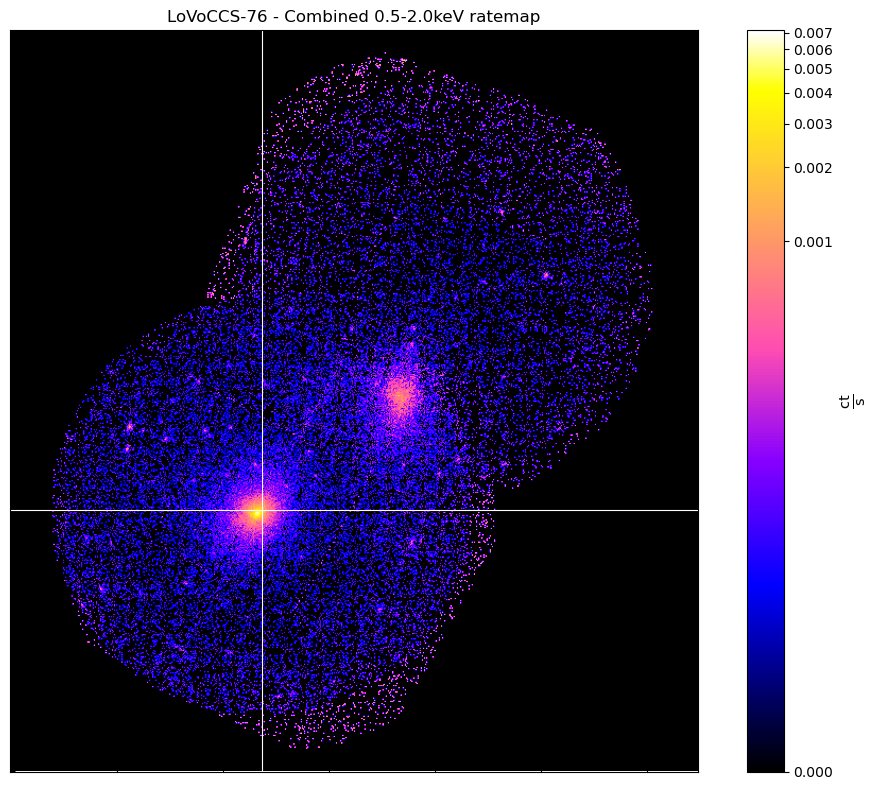

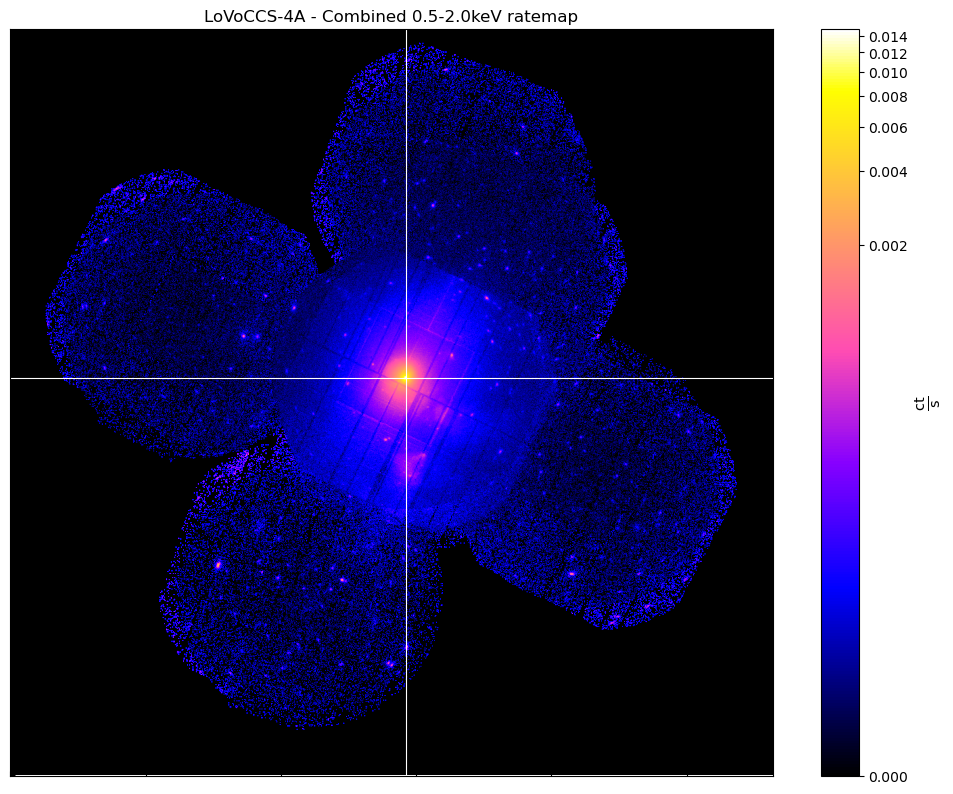

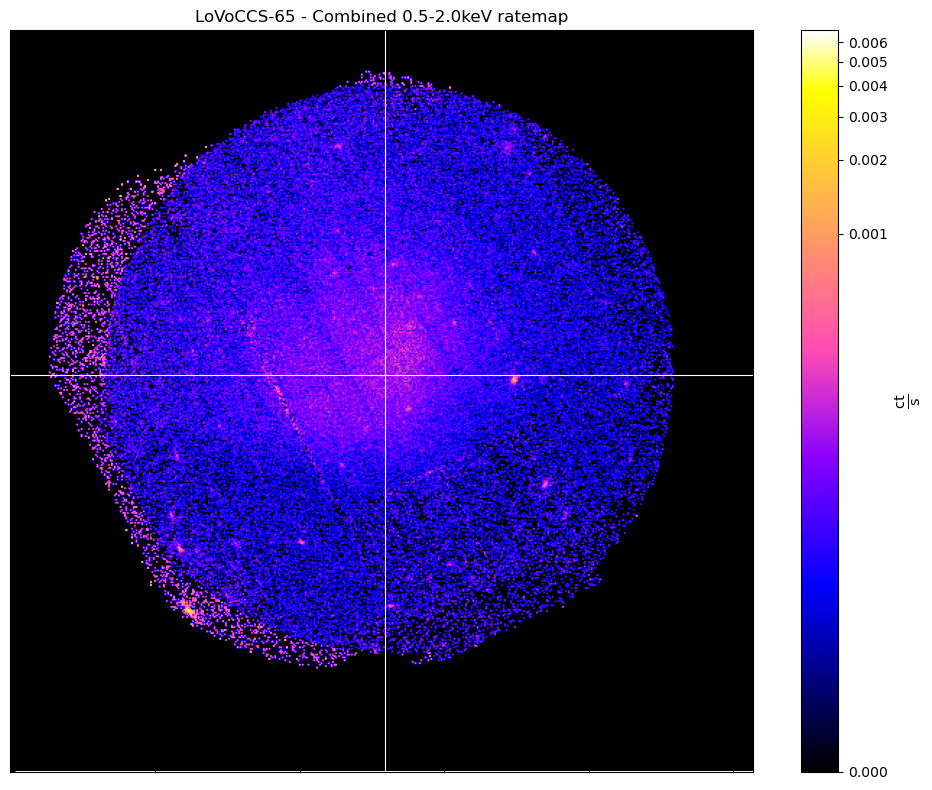

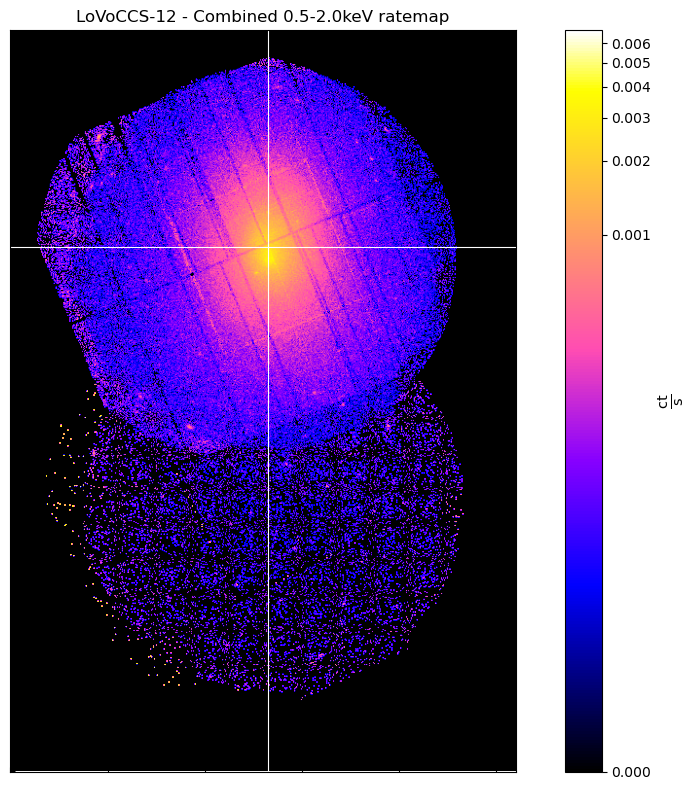

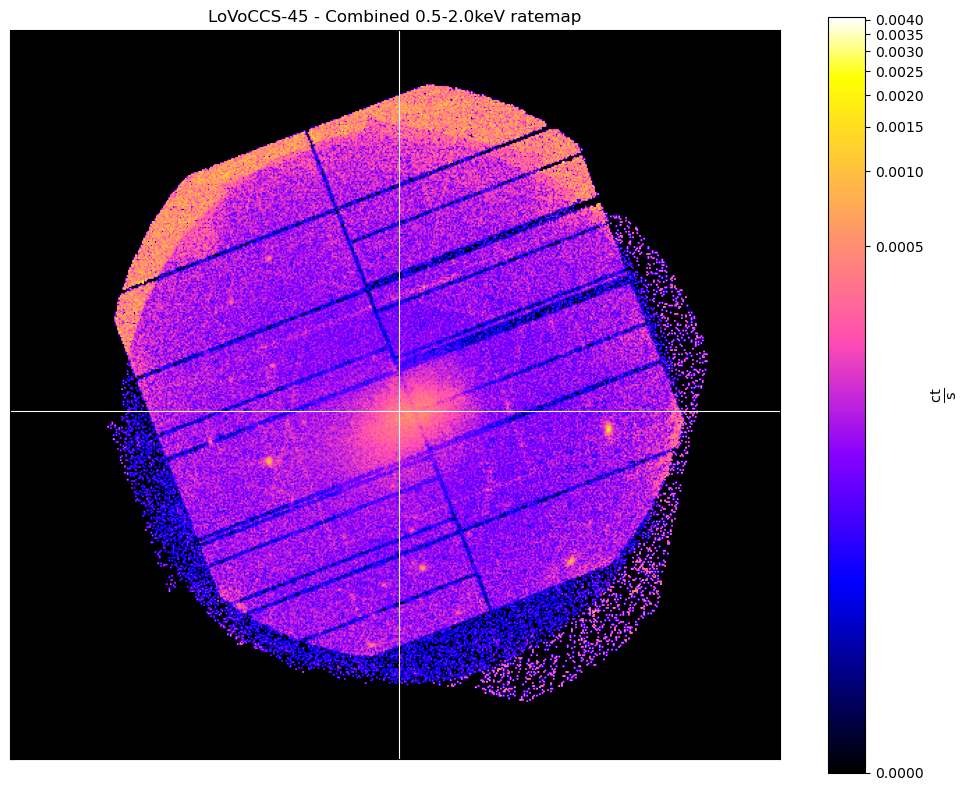

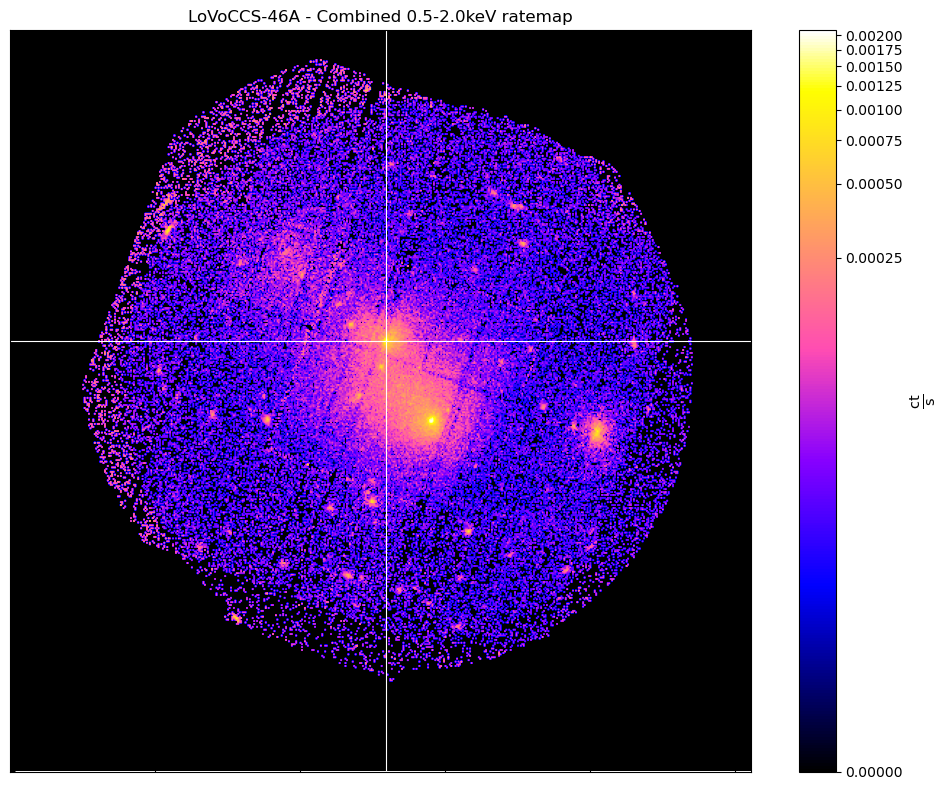

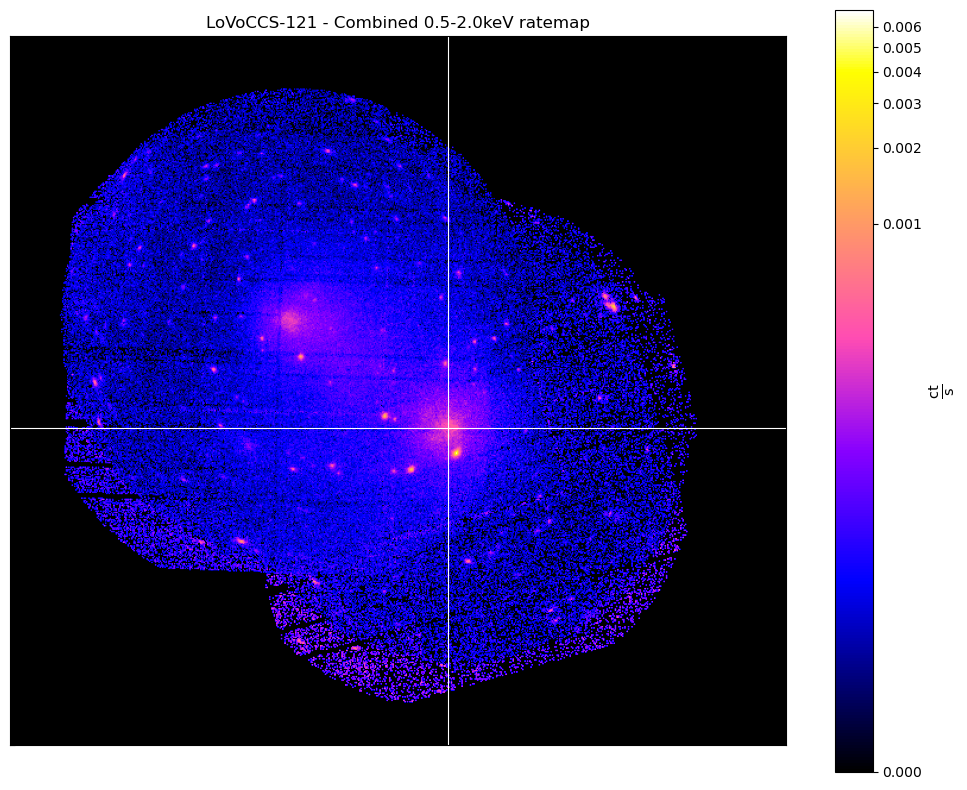

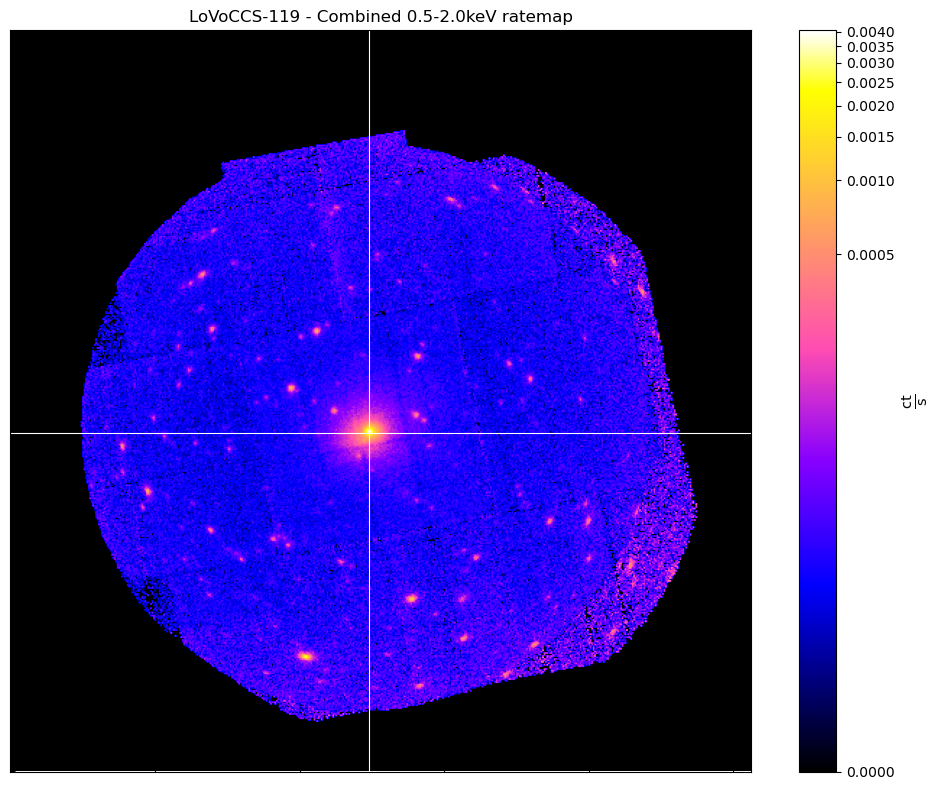

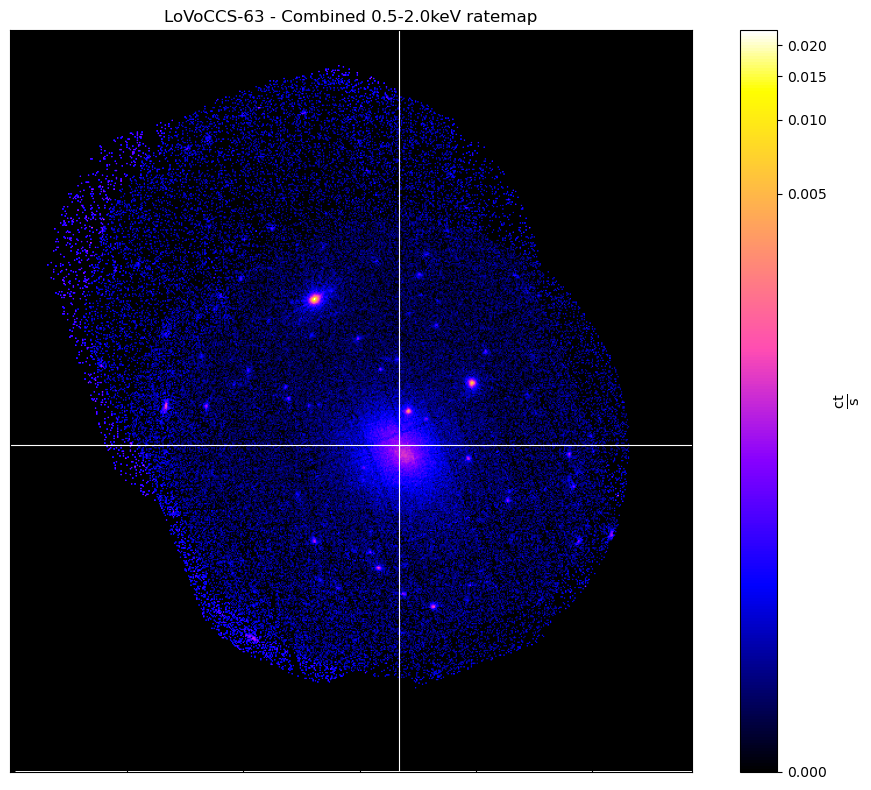

In [9]:
for src in srcs:
    rt = src.get_combined_ratemaps()
    rt.view(src.ra_dec)

## Removing problematic observations

In [10]:
# srcs['LoVoCCS-40'].disassociate_obs({'0502671101': ['mos2']})

## Generating projected temperature and metallicity profiles

### Minimum counts = 1500

In [11]:
rads = min_cnt_proj_temp_prof(srcs, srcs.r500, Quantity(1500, 'ct'), min_width=Quantity(20, 'arcsec'), one_rmf=False, 
                              freeze_met=False)

/mnt/ffs24/home/turne540/code/main_branch_xga/XGA/xga/products/phot.py:3070: RuntimeWarning: divide by zero encountered in scalar divide
  area_norm = src_area / back_area
/mnt/ffs24/home/turne540/code/main_branch_xga/XGA/xga/products/phot.py:3078: RuntimeWarning: invalid value encountered in scalar multiply
  cnts = Quantity(tot_cnt - (bck_cnt*area_norm), 'ct')
/mnt/ffs24/home/turne540/code/main_branch_xga/XGA/xga/products/phot.py:3070: RuntimeWarning: invalid value encountered in scalar divide
  area_norm = src_area / back_area
Generating products of type(s) annular spectrum set components:   0%|          | 0/2034 [00:13<?, ?it/s]

KeyboardInterrupt



We (temporarily) store the measured projected temperatures/metallicities (and the central position/width of their annular bins) in csvs, indicating in the name which minimum count was used. This will later be replaced by simply including XGA output profile files in the repository, but we first need to create a better way of outputting those profiles:

In [ ]:
bpo

In [ ]:
for rad_ind, rad in enumerate(rads):
    src = srcs[rad_ind]
    try:
        t_prof = src.get_proj_temp_profiles(radii=rad)
        
        data = np.concatenate([t_prof.values.value[..., None], t_prof.values_err.value[..., None], 
                               t_prof.radii.value[..., None], t_prof.radii_err.value[..., None]], axis=1)
        
        tp_df = pd.DataFrame(data, columns=['Tx', 'Tx_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_tproj_min1500ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir + file_name)
        
        met_prof = src.get_combined_profiles('1d_proj_metallicity', radii=rad)
        
        data = np.concatenate([met_prof.values.value[..., None], met_prof.values_err.value[..., None], 
                               met_prof.radii.value[..., None], met_prof.radii_err.value[..., None]], axis=1)
        
        metp_df = pd.DataFrame(data, columns=['met', 'met_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_metproj_min1500ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir_met + file_name)
        
    except NoProductAvailableError:
        pass

### Minimum counts = 3000

In [ ]:
rads_3000 = min_cnt_proj_temp_prof(srcs, srcs.r500, Quantity(3000, 'ct'), one_rmf=False, freeze_met=False)

We (temporarily) store the measured projected temperatures (and the central position/width of their annular bins) in csvs, indicating in the name which minimum count was used. This will later be replaced by simply including XGA output profile files in the repository, but we first need to create a better way of outputting those profiles:

In [ ]:
for rad_ind, rad in enumerate(rads_3000):
    src = srcs[rad_ind]
    try:
        t_prof = src.get_proj_temp_profiles(radii=rad)
        
        data = np.concatenate([t_prof.values.value[..., None], t_prof.values_err.value[..., None], 
                               t_prof.radii.value[..., None], t_prof.radii_err.value[..., None]], axis=1)
        
        tp_df = pd.DataFrame(data, columns=['Tx', 'Tx_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_tproj_min3000ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir + file_name)
        
        met_prof = src.get_combined_profiles('1d_proj_metallicity', radii=rad)
        
        data = np.concatenate([met_prof.values.value[..., None], met_prof.values_err.value[..., None], 
                               met_prof.radii.value[..., None], met_prof.radii_err.value[..., None]], axis=1)
        
        metp_df = pd.DataFrame(data, columns=['met', 'met_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_metproj_min3000ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir_met + file_name)
        
    except NoProductAvailableError:
        pass

### Minimum counts = 4000

In [ ]:
rads_4000 = min_cnt_proj_temp_prof(srcs, srcs.r500, Quantity(4000, 'ct'), one_rmf=False, freeze_met=False)

We (temporarily) store the measured projected temperatures (and the central position/width of their annular bins) in csvs, indicating in the name which minimum count was used. This will later be replaced by simply including XGA output profile files in the repository, but we first need to create a better way of outputting those profiles:

In [ ]:
for rad_ind, rad in enumerate(rads_4000):
    src = srcs[rad_ind]
    try:
        t_prof = src.get_proj_temp_profiles(radii=rad)
        
        data = np.concatenate([t_prof.values.value[..., None], t_prof.values_err.value[..., None], 
                               t_prof.radii.value[..., None], t_prof.radii_err.value[..., None]], axis=1)
        
        tp_df = pd.DataFrame(data, columns=['Tx', 'Tx_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_tproj_min4000ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir + file_name)
        
        met_prof = src.get_combined_profiles('1d_proj_metallicity', radii=rad)
        
        data = np.concatenate([met_prof.values.value[..., None], met_prof.values_err.value[..., None], 
                               met_prof.radii.value[..., None], met_prof.radii_err.value[..., None]], axis=1)
        
        metp_df = pd.DataFrame(data, columns=['met', 'met_err', 'rad', 'rad_width']).round(3)
        file_name = "{n}_metproj_min4000ct_toR500.csv".format(n=src.name)
        tp_df.to_csv(stor_dir_met + file_name)
        
    except NoProductAvailableError:
        pass

## Visualising different minimum count-rate profiles on the same figure

We create and save visualisations of the projected temperature and metallicity profiles, with all of our attempts at measuring their profiles (i.e. the different minimum count rates) plotted on the same axis.

In [ ]:
forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp)), 
         'xminor': FuncFormatter(lambda inp, _: '{:g}'.format(inp)), 
         'ymajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp)),
         'yminor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}

### Projected Temperature

In [ ]:
got_pt = 0
for src in srcs:
    try:
        pt = src.get_proj_temp_profiles()
        got_pt += 1
        file_name = "{n}_tproj_toR500.pdf".format(n=src.name)
        if isinstance(pt, list):
            pt = BaseAggregateProfile1D(pt)
            pt.view(xscale='linear', axis_formatters=forms, save_path=fig_dir + file_name)
        else:
            pt.view(xscale='linear', axis_formatters=forms)
            pt.save_view(fig_dir + file_name, xscale='linear', axis_formatters=forms)
        
    except NoProductAvailableError:
        print(src.name)
got_pt

### Projected Metallicity

In [ ]:
got_pm = 0
for src in srcs:
    try:
        pm = src.get_combined_profiles('1d_proj_metallicity')
        
        got_pm += 1        
        file_name = "{n}_metproj_toR500.pdf".format(n=src.name)
        if isinstance(pm, list):
            pm = BaseAggregateProfile1D(pm)
            pm.view(xscale='linear', axis_formatters=forms, save_path=fig_dir_met + file_name)
        else:
            pm.view(xscale='linear', axis_formatters=forms)
            pm.save_view(fig_dir_met + file_name, xscale='linear', axis_formatters=forms)
        
    except NoProductAvailableError:
        print(src.name)
got_pm

## Count-rate map and profile visualisations

Here we create side-by-side visualisations of profiles and ratemaps with annuli overlaid, to aid in diagnostics. **Note that we only display the first ten, in order to keep this notebook's file size small enough to render on GitHub - all these figures are saved to disk however.**

In [ ]:
for rad_ind, rad in enumerate(rads):
    src = srcs[rad_ind]
    try:
        tp = src.get_proj_temp_profiles(radii=rad)
        rt = src.get_combined_ratemaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))

        fig, ax_arr = plt.subplots(1, 2, figsize=(10, 5))
        ax = ax_arr[0]
        tp.get_view(fig, ax, custom_title='', xscale='linear', axis_formatters=forms)

        ax = ax_arr[1]
        pix_rads = (rad/pix_deg_scale(src.ra_dec, rt.radec_wcs)).to('pix')
        pix_cen = rt.coord_conv(src.ra_dec, 'pix')
        x_lims = [(pix_cen[0]-pix_rads[-1]).value-2, (pix_cen[0]+pix_rads[-1]).value+2]
        y_lims = [(pix_cen[1]-pix_rads[-1]).value-2, (pix_cen[1]+pix_rads[-1]).value+2]

        rt.get_view(ax, src.ra_dec, src.get_interloper_mask(), custom_title='', zoom_in=True, 
                    radial_bins_pix=pix_rads.value, manual_zoom_xlims=x_lims, manual_zoom_ylims=y_lims)

        plt.tight_layout()
        file_name = "{n}_tproj_ratemap_toR500_diagnostic.pdf".format(n=src.name)
        plt.savefig(fig_dir_diag + file_name)
        if rad_ind < 10:    
            plt.show()
        plt.close('all')
    except NoProductAvailableError:
        pass